**Задача 4**

1. Найти графовый набор данных для решения задачи предсказания (классификация вершин, обнаружение сообществ и т.д.).
2. Использовать несколько слоев GATConv из библиотеки PyG для построения GAT модели.
3. Обучить полученную модель, подобрать гиперпараметры (например, learning rate) на валидационной выборке, и оценить качество предсказания на тестовой выборке.
4. (+5 баллов) Также найти набор данных, с помощью которого можно получить гетерогенный граф. Использовать несколько слоев RGATConv из библиотеки PyG для построения Relational GAT модели. Разбить данные на тренировочные/валидационные/тестовые с помощью средств PyG, например RandomLinkSplit для задачи Link Prediction. Обучить полученную модель, подобрать гиперпараметры (например, learning rate, multi-head attention) на валидационной выборке, и оценить качество предсказания на тестовой выборке.

In [ ]:
# импорт основных библиотек

import numpy as np
import pandas as pd
import random

import networkx as nx
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

import os
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# загрузка специальных пакетов

!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
import torch_geometric.utils
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import torch_geometric.transforms as T

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# загрузим набор данных

name_data = 'Cora'
dataset = Planetoid(root= '/tmp/' + name_data, name = name_data)
dataset.transform = T.NormalizeFeatures()

Processing...
Done!


In [ ]:
# выведим полезную информацию о рассматриваемом графе:
# количество признаков, количество классов
# количество вершин и рёбер
# средняя степень вершин......

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [ ]:
# составим класс GAT

class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.hid = 8
        self.in_head = 8
        self.out_head = 1


        #self.conv1 = GATLayer(dataset.num_features, self.hid, dropout=0.6,
        #                      alpha=0.2)
        #self.conv2 = GATLayer(self.hid, dataset.num_classes,
        #                      dropout=0.6, alpha=0.2, concat=False)

        self.conv1 = GATConv(dataset.num_features, self.hid, heads=self.in_head, dropout=0.6)
        self.conv2 = GATConv(self.hid*self.in_head, dataset.num_classes, concat=False,
                             heads=self.out_head, dropout=0.6)

    def forward(self, data, adj):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training=self.training)
        #x = self.conv1(x, adj)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        #x = self.conv2(x, adj)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"

data = dataset[0].to(device)
adj = torch.squeeze(torch_geometric.utils.to_dense_adj(data.edge_index)) # from edge_index (coo format) to dense adj matrix (naive implementation)


**Подберём гиперпараметр.** <br>
**Будем работать с learning rate**

**learning rate = 0.05**

In [ ]:
model = GAT().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=5e-4)

In [ ]:
# обучение модели
model.train()
for epoch in range(300):
    model.train()
    optimizer.zero_grad()
    out = model(data, adj)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])

    if epoch%10 == 0:
        print(loss)

    loss.backward()
    optimizer.step()

tensor(1.9469, grad_fn=<NllLossBackward0>)
tensor(1.2021, grad_fn=<NllLossBackward0>)
tensor(0.9219, grad_fn=<NllLossBackward0>)
tensor(0.6408, grad_fn=<NllLossBackward0>)
tensor(0.7008, grad_fn=<NllLossBackward0>)
tensor(0.7053, grad_fn=<NllLossBackward0>)
tensor(0.6808, grad_fn=<NllLossBackward0>)
tensor(0.6461, grad_fn=<NllLossBackward0>)
tensor(0.7699, grad_fn=<NllLossBackward0>)
tensor(0.6766, grad_fn=<NllLossBackward0>)
tensor(0.5890, grad_fn=<NllLossBackward0>)
tensor(0.7046, grad_fn=<NllLossBackward0>)
tensor(0.7093, grad_fn=<NllLossBackward0>)
tensor(0.7484, grad_fn=<NllLossBackward0>)
tensor(0.6469, grad_fn=<NllLossBackward0>)
tensor(0.7246, grad_fn=<NllLossBackward0>)
tensor(0.6284, grad_fn=<NllLossBackward0>)
tensor(0.6922, grad_fn=<NllLossBackward0>)
tensor(0.7211, grad_fn=<NllLossBackward0>)
tensor(0.5894, grad_fn=<NllLossBackward0>)
tensor(0.6597, grad_fn=<NllLossBackward0>)
tensor(0.6538, grad_fn=<NllLossBackward0>)
tensor(0.6458, grad_fn=<NllLossBackward0>)
tensor(0.60

In [ ]:
# оценка качества модели

model.eval()
_, pred = model(data, adj).max(dim=1)
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.7960


**Повторяем при lr=0.005**

In [ ]:
del model
del optimizer

model = GAT().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

In [ ]:
# обучение модели
model.train()
for epoch in range(300):
    model.train()
    optimizer.zero_grad()
    out = model(data, adj)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])

    if epoch%10 == 0:
        print(loss)

    loss.backward()
    optimizer.step()

tensor(1.9449, grad_fn=<NllLossBackward0>)
tensor(1.8754, grad_fn=<NllLossBackward0>)
tensor(1.7834, grad_fn=<NllLossBackward0>)
tensor(1.6501, grad_fn=<NllLossBackward0>)
tensor(1.5443, grad_fn=<NllLossBackward0>)
tensor(1.3822, grad_fn=<NllLossBackward0>)
tensor(1.2355, grad_fn=<NllLossBackward0>)
tensor(1.1619, grad_fn=<NllLossBackward0>)
tensor(1.0878, grad_fn=<NllLossBackward0>)
tensor(0.9334, grad_fn=<NllLossBackward0>)
tensor(0.9416, grad_fn=<NllLossBackward0>)
tensor(0.8786, grad_fn=<NllLossBackward0>)
tensor(0.7952, grad_fn=<NllLossBackward0>)
tensor(0.7707, grad_fn=<NllLossBackward0>)
tensor(0.7318, grad_fn=<NllLossBackward0>)
tensor(0.6770, grad_fn=<NllLossBackward0>)
tensor(0.8111, grad_fn=<NllLossBackward0>)
tensor(0.7926, grad_fn=<NllLossBackward0>)
tensor(0.7481, grad_fn=<NllLossBackward0>)
tensor(0.6994, grad_fn=<NllLossBackward0>)
tensor(0.6880, grad_fn=<NllLossBackward0>)
tensor(0.6076, grad_fn=<NllLossBackward0>)
tensor(0.6756, grad_fn=<NllLossBackward0>)
tensor(0.68

In [ ]:
# оценка качества модели

model.eval()
_, pred = model(data, adj).max(dim=1)
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.8260


Повторяем при lr=0.0005

In [ ]:
del model
del optimizer

model = GAT().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=5e-4)

In [ ]:
# обучение модели
model.train()
for epoch in range(300):
    model.train()
    optimizer.zero_grad()
    out = model(data, adj)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])

    if epoch%10 == 0:
        print(loss)

    loss.backward()
    optimizer.step()

tensor(1.9463, grad_fn=<NllLossBackward0>)
tensor(1.9383, grad_fn=<NllLossBackward0>)
tensor(1.9304, grad_fn=<NllLossBackward0>)
tensor(1.9212, grad_fn=<NllLossBackward0>)
tensor(1.9171, grad_fn=<NllLossBackward0>)
tensor(1.9122, grad_fn=<NllLossBackward0>)
tensor(1.9012, grad_fn=<NllLossBackward0>)
tensor(1.8990, grad_fn=<NllLossBackward0>)
tensor(1.8932, grad_fn=<NllLossBackward0>)
tensor(1.8793, grad_fn=<NllLossBackward0>)
tensor(1.8742, grad_fn=<NllLossBackward0>)
tensor(1.8628, grad_fn=<NllLossBackward0>)
tensor(1.8567, grad_fn=<NllLossBackward0>)
tensor(1.8495, grad_fn=<NllLossBackward0>)
tensor(1.8370, grad_fn=<NllLossBackward0>)
tensor(1.8124, grad_fn=<NllLossBackward0>)
tensor(1.7855, grad_fn=<NllLossBackward0>)
tensor(1.8007, grad_fn=<NllLossBackward0>)
tensor(1.7881, grad_fn=<NllLossBackward0>)
tensor(1.7548, grad_fn=<NllLossBackward0>)
tensor(1.7627, grad_fn=<NllLossBackward0>)
tensor(1.7415, grad_fn=<NllLossBackward0>)
tensor(1.7159, grad_fn=<NllLossBackward0>)
tensor(1.70

In [ ]:
# оценка качества модели

model.eval()
_, pred = model(data, adj).max(dim=1)
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.7830


**Вывод по подбору параметра:**

Лучший результат был получен при lr=0.005

Используем данное значение параметра для следующего обучения

Увеличим количество эпох до 500

In [ ]:
del model
del optimizer

model = GAT().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

In [ ]:
# обучение модели
# каждые 10 эпох будем выводить значение функции ошибки

model.train()
for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    out = model(data, adj)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])

    if epoch%10 == 0:
        print(loss)

    loss.backward()
    optimizer.step()

tensor(1.9473, grad_fn=<NllLossBackward0>)
tensor(1.8843, grad_fn=<NllLossBackward0>)
tensor(1.7836, grad_fn=<NllLossBackward0>)
tensor(1.6312, grad_fn=<NllLossBackward0>)
tensor(1.5291, grad_fn=<NllLossBackward0>)
tensor(1.3637, grad_fn=<NllLossBackward0>)
tensor(1.2699, grad_fn=<NllLossBackward0>)
tensor(1.1592, grad_fn=<NllLossBackward0>)
tensor(1.1281, grad_fn=<NllLossBackward0>)
tensor(0.9923, grad_fn=<NllLossBackward0>)
tensor(0.8889, grad_fn=<NllLossBackward0>)
tensor(0.8962, grad_fn=<NllLossBackward0>)
tensor(0.8461, grad_fn=<NllLossBackward0>)
tensor(0.8271, grad_fn=<NllLossBackward0>)
tensor(0.8344, grad_fn=<NllLossBackward0>)
tensor(0.7252, grad_fn=<NllLossBackward0>)
tensor(0.7325, grad_fn=<NllLossBackward0>)
tensor(0.6964, grad_fn=<NllLossBackward0>)
tensor(0.7244, grad_fn=<NllLossBackward0>)
tensor(0.7158, grad_fn=<NllLossBackward0>)
tensor(0.6780, grad_fn=<NllLossBackward0>)
tensor(0.6626, grad_fn=<NllLossBackward0>)
tensor(0.7084, grad_fn=<NllLossBackward0>)
tensor(0.67

In [ ]:
model.eval()
_, pred = model(data, adj).max(dim=1)
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.8160


In [ ]:
# Составим (скопируем из блокнота практики) функцию,
# которая будет использоваться для графического отображения

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

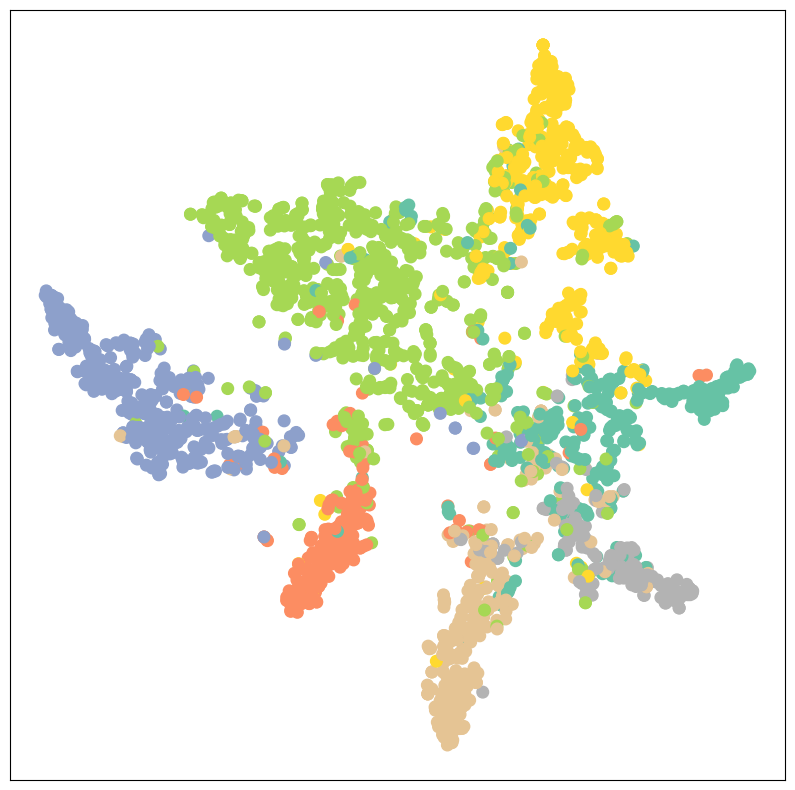

In [ ]:
# применим модель и отобразим результат

model.eval()

out = model(data, adj)
visualize(out, color=data.y)

**Выводы:**

Графическое отображение показывает, что модель вполне эффективно разделяет данные на заданное число классов.